<a href="https://colab.research.google.com/github/artemkush1/GAN_mnist/blob/master/mnist_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gan

In [99]:
from keras.layers import Input, Dense, Lambda, LeakyReLU, Reshape, Flatten
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [138]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
z_dim = 100

In [163]:
def build_generator(img_shape, z_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    model.add(Reshape(img_shape))
    return model

generator = build_generator(img_shape, z_dim)
# generator.compile(loss='binary_crossentropy', optimizer=optimizer)

In [164]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(1, activation='sigmoid'))
    return model

discriminator = build_discriminator(img_shape)

In [165]:
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [166]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(lr=0.0002, beta_1=0.5),
                      metrics=['accuracy'])
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

In [167]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

In [168]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    for iteration in range(iterations):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = np.add(d_loss_real, d_loss_fake) * 0.5

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            sample_images(generator)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: 0.454886, acc.: 77.34%] [G loss: 1.529136]


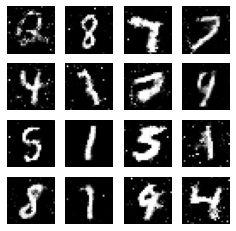

In [171]:
iterations = 20000
batch_size = 512
sample_interval = 1000

train(iterations, batch_size, sample_interval)

# DCGAN

In [209]:
from keras.layers import Input, Dense, Lambda, LeakyReLU, Reshape, Flatten, Conv2DTranspose, Conv2D, BatchNormalization
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [210]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
z_dim = 100

In [241]:
def build_generator(img_shape, z_dim):
    model = Sequential()
    model.add(Dense(7*7*128, input_dim=z_dim))
    model.add(Reshape((7, 7, 128)))
    model.add(Conv2DTranspose(128, 4, strides=1, padding='same'))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(64, 4, strides=2, padding='same'))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(32, 4, strides=2, padding='same'))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(1, 4, strides=1, padding='same'))
    return model

generator = build_generator(img_shape, z_dim)
generator.summary()

Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 6272)              633472    
_________________________________________________________________
reshape_33 (Reshape)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_35 (Conv2DT (None, 7, 7, 128)         262272    
_________________________________________________________________
leaky_re_lu_83 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_36 (Conv2DT (None, 14, 14, 64)        131136    
_________________________________________________________________
leaky_re_lu_84 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_37 (Conv2DT (None, 28, 28, 32)      

In [242]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Conv2D(32, 4, strides=2, input_shape=img_shape, padding='same'))
    #model.add(BatchNormalization(0.9))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64, 4, strides=2, padding='same'))
    #model.add(BatchNormalization(0.9))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, 4, strides=2, padding='same'))
    #model.add(BatchNormalization(0.9))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

discriminator = build_discriminator(img_shape)
discriminator.summary()

Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 14, 14, 32)        544       
_________________________________________________________________
leaky_re_lu_86 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 7, 7, 64)          32832     
_________________________________________________________________
leaky_re_lu_87 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 4, 4, 128)         131200    
_________________________________________________________________
leaky_re_lu_88 (LeakyReLU)   (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 2048)            

In [243]:
def build_gan(generator, discriminator, z_dim):
    discriminator.trainable = False
    gan_input = Input(shape=(z_dim,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    return gan

In [244]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])  # lr=0.0002, beta_1=0.5
gan = build_gan(generator, discriminator, z_dim)
gan.compile(loss='binary_crossentropy', optimizer=Adam())  # lr=0.0002, beta_1=0.5

In [245]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

In [246]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    for iteration in range(iterations):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = np.add(d_loss_real, d_loss_fake) * 0.5

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            sample_images(generator)

14000 [D loss: 0.246445, acc.: 90.62%] [G loss: 4.934918]


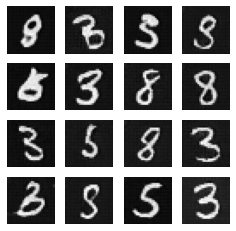

15000 [D loss: 0.237796, acc.: 90.62%] [G loss: 4.165358]


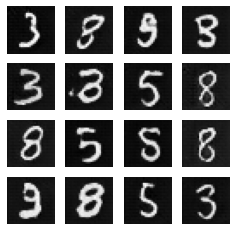

16000 [D loss: 0.233246, acc.: 89.84%] [G loss: 4.943638]


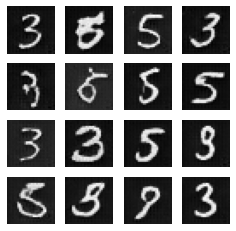

17000 [D loss: 0.180263, acc.: 91.80%] [G loss: 4.757192]


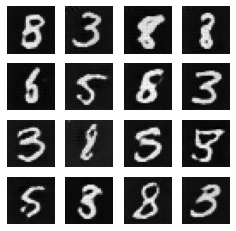

18000 [D loss: 0.345442, acc.: 88.28%] [G loss: 2.866272]


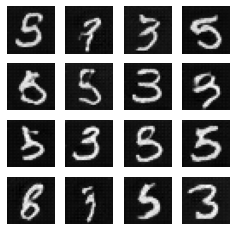

19000 [D loss: 0.175368, acc.: 92.58%] [G loss: 3.589543]


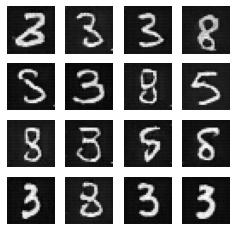

20000 [D loss: 0.155140, acc.: 92.58%] [G loss: 4.802672]


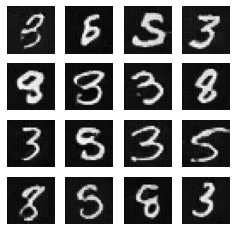

In [247]:
iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)